<a href="https://colab.research.google.com/github/Kangjuheon/Targeted_PGD_MNIST/blob/main/Targeted_PGD_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. 라이브러리 설치 및 GPU 연결**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# GPU 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


###**2. 데이터 불러오기**

In [3]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


In [4]:
# 한 배치 꺼내기
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("입력 이미지 모양:", example_data.shape)
print("정답 라벨:", example_targets[:10])  # 앞 10개만 출력

입력 이미지 모양: torch.Size([1000, 1, 28, 28])
정답 라벨: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


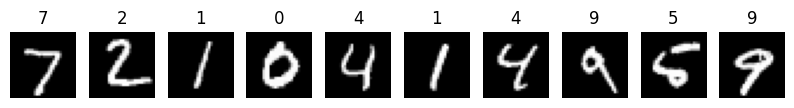

In [5]:
# 앞에서 가져온 example_data로 이미지 출력
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')  # [0]은 채널 추출
    plt.title(str(example_targets[i].item()))
    plt.axis('off')
plt.show()

###**3. CNN 모델**

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

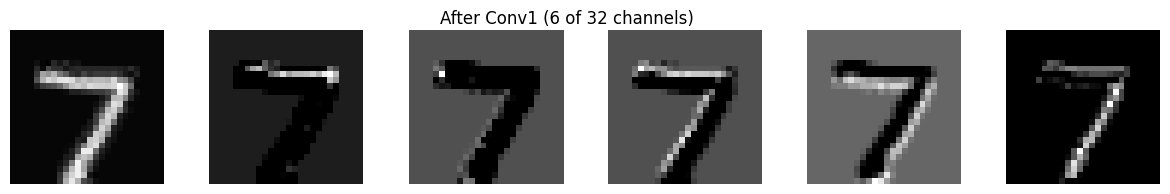

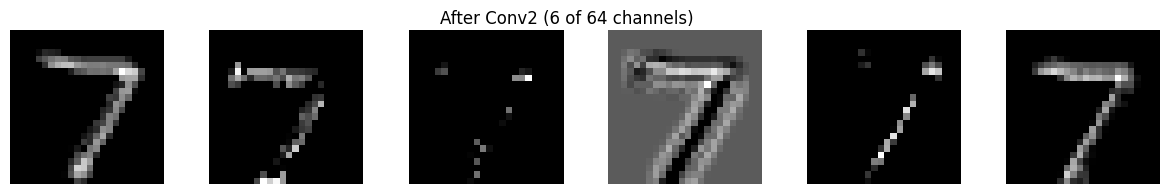

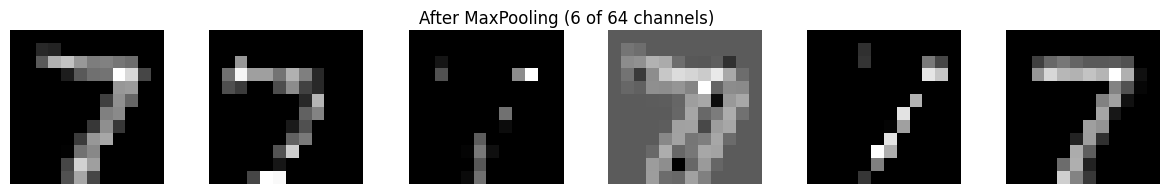

In [7]:
# 모델에서 중간 결과를 보기 위해 일부만 분리
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.conv1 = model.conv1
        self.conv2 = model.conv2

    def forward(self, x):
        x = F.relu(self.conv1(x))     # conv1 출력
        out1 = x.detach().cpu()       # 저장용
        x = F.relu(self.conv2(x))     # conv2 출력
        out2 = x.detach().cpu()
        x = F.max_pool2d(x, 2)        # pooling 후
        out3 = x.detach().cpu()
        return out1, out2, out3

# 모델 연결
extractor = FeatureExtractor(model).to(device)

# 테스트 이미지 하나 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)  # 배치 차원 추가

# 특징 추출
feat1, feat2, feat3 = extractor(img)

# 시각화 함수
def plot_features(features, title, num_channels=6):
    plt.figure(figsize=(15, 2))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(features[0, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 그리기
plot_features(feat1, "After Conv1 (6 of 32 channels)")
plot_features(feat2, "After Conv2 (6 of 64 channels)")
plot_features(feat3, "After MaxPooling (6 of 64 channels)")


###**4. 모델 학습**

In [8]:
model = SimpleCNN().to(device) #모델 초기화

In [9]:
train_losses = []       # 손실 저장 리스트
test_accuracies = []    # 정확도 저장 리스트 추가

def train(model, train_loader, epochs=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 정확도 측정 및 저장
        acc = test_accuracy(model, test_loader)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += len(data)
    acc = 100 * correct / total
    return acc

train(model, train_loader)

Epoch 1, Loss: 0.1572, Accuracy: 98.51%
Epoch 2, Loss: 0.0435, Accuracy: 98.67%
Epoch 3, Loss: 0.0275, Accuracy: 98.96%
Epoch 4, Loss: 0.0181, Accuracy: 98.68%


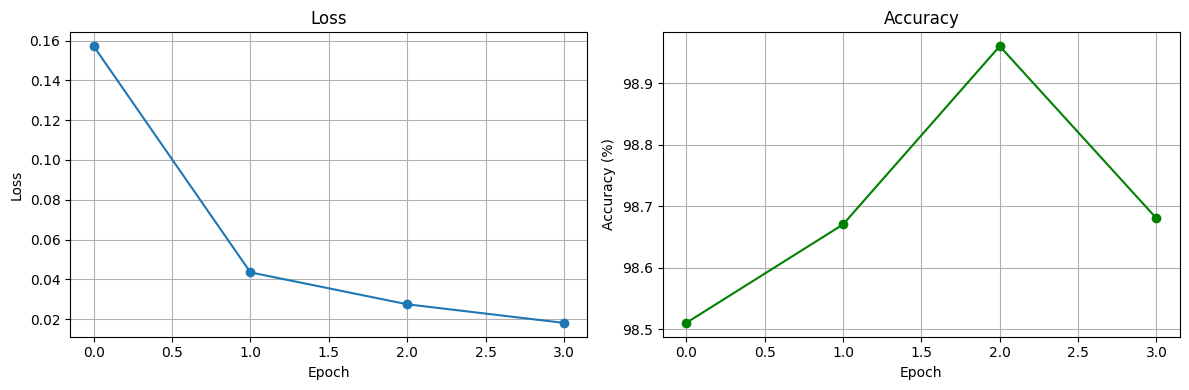

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

###**5. FGSM (untargeted) 구현**

In [11]:
def pgd_targeted(model, x, target, k, eps, eps_step):
    x_orig = x.clone().detach().to(device)
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    for i in range(k):
        output = model(x_adv)
        loss = F.cross_entropy(output, target.to(device))
        model.zero_grad()
        loss.backward()
        grad_sign = x_adv.grad.data.sign()
        x_adv = x_adv - eps_step * grad_sign
        eta = torch.clamp(x_adv - x_orig, min=-eps, max=eps)
        x_adv = x_orig + eta
        x_adv = torch.clamp(x_adv, 0, 1)
        x_adv = x_adv.detach()
        x_adv.requires_grad = True

    return x_adv.detach()

In [12]:
import random
import matplotlib.pyplot as plt

def visualize_multiple_pgd_attacks(model, dataset, num_samples=5, k=10, eps=0.3, eps_step=0.03):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, 3 * num_samples))

    for i, idx in enumerate(indices):
        x, label = dataset[idx]
        x = x.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # 정답이 아닌 target 클래스 무작위 선택
        all_classes = list(range(10))
        all_classes.remove(label.item())
        target_class = random.choice(all_classes)
        target = torch.tensor([target_class]).to(device)

        # PGD 공격
        x_adv = pgd_targeted(model, x, target, k=k, eps=eps, eps_step=eps_step)

        # 모델 예측
        pred_orig = model(x).argmax(dim=1).item()
        pred_adv = model(x_adv).argmax(dim=1).item()

        # 시각화용 텐서 정리
        orig = x.squeeze().detach().cpu()
        adv = x_adv.squeeze().detach().cpu()
        diff = (adv - orig).abs()

        # 플롯
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f"origin\n정답: {label.item()} / Predict: {pred_orig}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(adv, cmap='gray')
        plt.title(f"Attack(target: {target_class})\nPredict: {pred_adv}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(diff, cmap='hot')
        plt.title("gap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-464740bf3d8b>:49: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<i

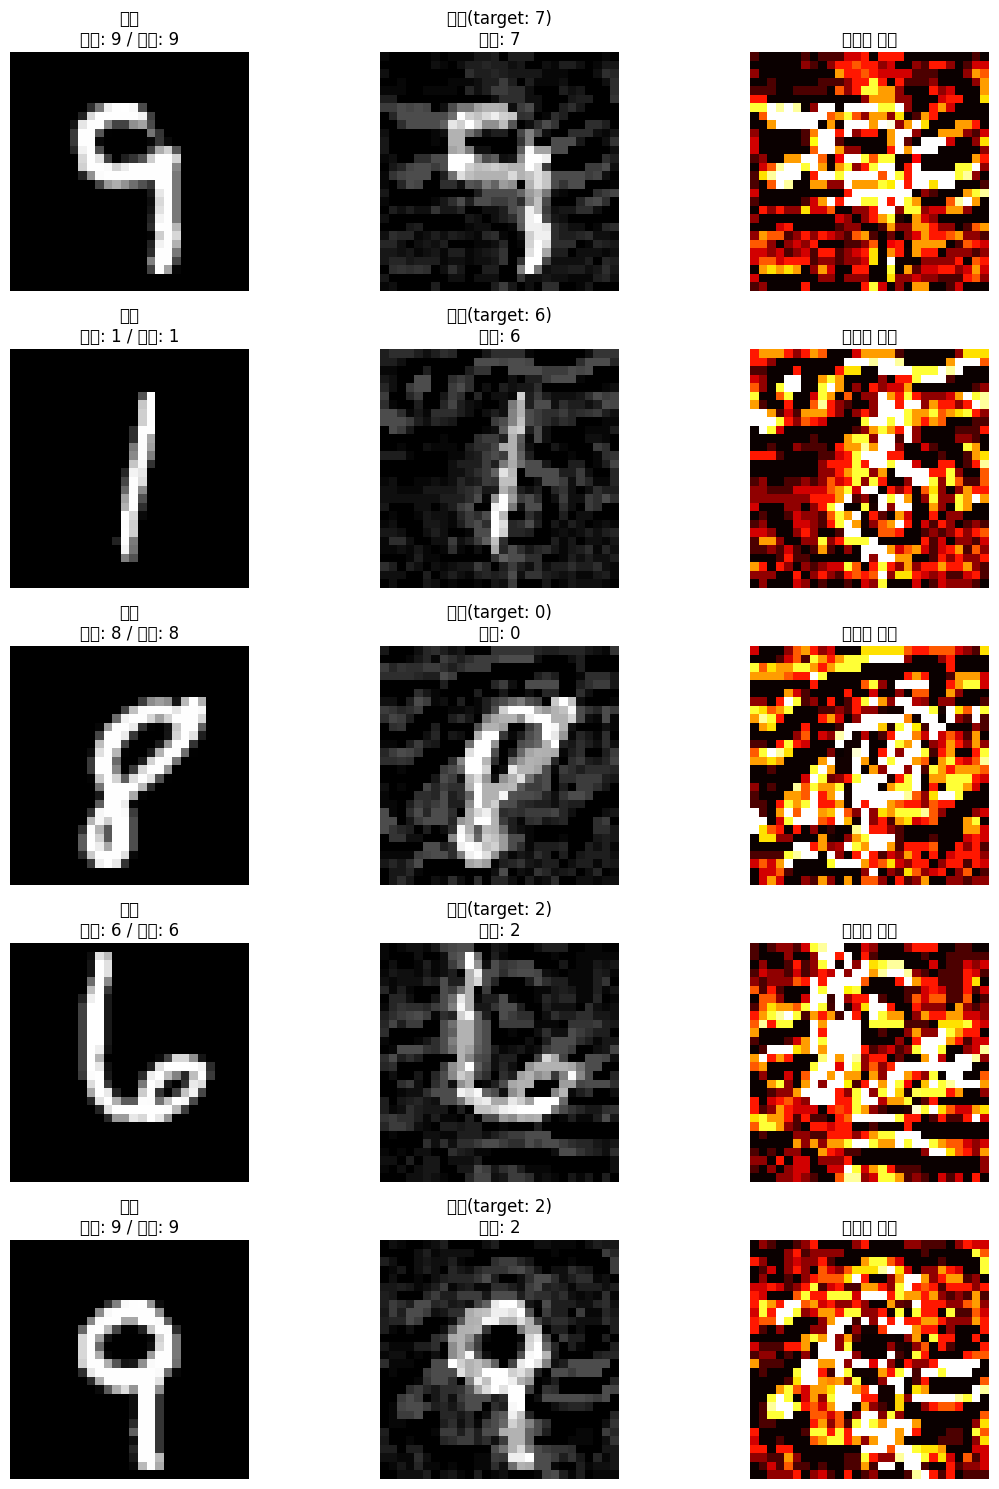

In [13]:
visualize_multiple_pgd_attacks(model, test_dataset, num_samples=5, k=10, eps=0.3, eps_step=0.03)

###**6. 테스트 함수: 공격 전후 정확도 비교**

In [14]:
def test_pgd_targeted_success_rate(model, test_loader, k=10, eps=0.3, eps_step=0.03, fixed_target=None):
    model.eval()
    total = 0
    success = 0

    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # target 설정
        if fixed_target is not None:
            target = torch.full_like(label, fixed_target).to(device)
        else:
            target = torch.randint(0, 10, label.shape).to(device)
            mask = target == label
            while mask.any():
                target[mask] = torch.randint(0, 10, (mask.sum(),)).to(device)
                mask = target == label

        # 공격 수행
        data_adv = pgd_targeted(model, data, target, k, eps, eps_step)
        output_adv = model(data_adv)
        pred_adv = output_adv.argmax(dim=1)

        # 성공한 공격 개수
        success += pred_adv.eq(target).sum().item()
        total += len(data)

    success_rate = 100 * success / total
    print(f"[PGD Targeted Attack] eps={eps}, k={k} → Success Rate: {success_rate:.2f}%")
    return success_rate

test_pgd_targeted_success_rate(model, test_loader, k=10, eps=0.3, eps_step=0.03)
test_pgd_targeted_success_rate(model, test_loader, fixed_target=7)

[PGD Targeted Attack] eps=0.3, k=10 → Success Rate: 96.57%
[PGD Targeted Attack] eps=0.3, k=10 → Success Rate: 98.76%


98.76

In [15]:
import numpy as np

def pgd_success_rates_by_target(model, test_loader, epsilons, k=10, eps_step_ratio=0.1):
    model.eval()
    results = {target: [] for target in range(10)}

    for target_class in range(10):
        print(f"\n[Target {target_class}]")
        for eps in epsilons:
            eps_step = eps * eps_step_ratio
            total = 0
            success = 0

            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                mask = label != target_class
                if mask.sum() == 0:
                    continue

                data = data[mask]
                target = torch.full_like(label[mask], target_class).to(device)

                data_adv = pgd_targeted(model, data, target, k, eps, eps_step)
                output_adv = model(data_adv)
                pred_adv = output_adv.argmax(dim=1)

                success += pred_adv.eq(target).sum().item()
                total += len(data)

            rate = 100 * success / total if total > 0 else 0
            print(f"  eps={eps:.2f} → {rate:.2f}%")
            results[target_class].append(rate)

    return results

In [16]:
import matplotlib.pyplot as plt

# 실험할 epsilon 값들
epsilons = np.linspace(0.05, 0.4, 8)
results = pgd_success_rates_by_target(model, test_loader, epsilons, k=10)

# 곡선 그래프 그리기
plt.figure(figsize=(10, 6))
for target_class, rates in results.items():
    plt.plot(epsilons, rates, marker='o', label=f'Target {target_class}')

plt.xlabel("Epsilon (Attack Strength)")
plt.ylabel("Targeted PGD Success Rate (%)")
plt.title("PGD Success Rate per Target Class")
plt.legend(title="Target", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


[Target 0]
  eps=0.05 → 0.50%
  eps=0.10 → 1.77%
  eps=0.15 → 7.18%


KeyboardInterrupt: 

##**7. 인사이트**

- 변형 정도가 0.2~0.3 정도면 봐줄만 한데, Accuracy는 기존 99%에서 절반 이하로 급격하게 감소한다. -> robust 하지 않다.
- MNIST의 Label 중 0과 1에서 Attack이 약한 편으로 보인다.
- Attack이 pixel 전체의 전방위적으로 들어가며 특히 문자 주변에서 일어난다.